In [1]:
import numpy as np
class Node:
    """
    我们把这个Node类作为这个神经网络的基础模块
    """
    def __init__(self,inputs=[],name=None,is_trainable=False):
        
        self.inputs = inputs  #这个节点的输入，输入的是Node组成的列表
        self.outputs = []     #这个节点的输出节点
        self.name = name
        self.is_trainable = is_trainable
        for n in self.inputs:
            n.outputs.append(self)  #这个节点正好对应了这个输人的输出节点，从而建立了连接关系
            
        self.value = None  #每个节点必定对应有一个值
        self.gradients = {}  #每个节点对上个节点的梯度，
                             
    def forward(self):
        """
        先预留一个方法接口不实现，在其子类中实现,且要求其子类一定要实现，不实现的时话会报错。
        """
        raise NotImplemented  
        
    def backward(self):
        
        raise NotImplemented
        
    def __repr__(self):
        
        return "Node:{}".format(self.name)  


In [2]:
class Placeholder(Node):
    """
    作为x,k,b,weights和bias这类需要赋初始值和更新值的类
    """
    def __init__(self,name,is_trainable=True):
        
        Node.__init__(self,name=name,is_trainable=is_trainable)
        
    def forward(self,value=None):
        
        if value is not None: self.value = value
        
    def backward(self):
        
        self.gradients[self] = 0.
        for n in self.outputs:
            
            self.gradients[self] += n.gradients[self]  #没有输入。
            
class Linear(Node):
    
    def __init__(self,x=None,weight=None,bias=None,name=None,is_trainable=False):
        
        Node.__init__(self,[x,weight,bias],name=name,is_trainable=is_trainable)
        
    def forward(self):
        
        k, x, b = self.inputs[1],self.inputs[0],self.inputs[2]
        self.value = k.value * x.value + b.value
        
    def backward(self):
        
        k, x, b = self.inputs[1],self.inputs[0],self.inputs[2]
        
        self.gradients[k] = 0.
        self.gradients[b] = 0.
        self.gradients[x] = 0.
        
        for n in self.outputs:
#             print("xxxxxx", len(self.outputs))
            
            gradients_from_loss_to_self = n.gradients[self]
            self.gradients[k] += gradients_from_loss_to_self*x.value
            self.gradients[b] += gradients_from_loss_to_self*1
            self.gradients[x] += gradients_from_loss_to_self*k.value

class Sigmoid(Node):
    
    def __init__(self,x,name,is_trainable=False):
     
        Node.__init__(self,[x],name=name,is_trainable=is_trainable)
        self.x = self.inputs[0]
    
    def _Sigmoid(self,x):
        
        return 1. /(1+np.exp(-1*x))
    
    def forward(self):
        
        self.value = self._Sigmoid(self.x.value)
        
    def partial(self):
        
        return self._Sigmoid(self.x.value) * (1 - self._Sigmoid(self.x.value))
    
    def backward(self):
        
        self.gradients[self.x] = 0.
        for n in self.outputs:
            gradients_from_loss_to_self = n.gradients[self]  #输出节点对这个节点的偏导，self：指的是本身这个节点
            self.gradients[self.x] += gradients_from_loss_to_self * self.partial()

class MSE(Node):
    
    def __init__(self,y_pre,y,name,is_trainable=False):
        
        Node.__init__(self,[y_pre,y],name=name,is_trainable=is_trainable)
        self.y_pre, self.y = self.inputs[0],self.inputs[1]
        
    def _MSE(self):
        
        y = np.array(self.y.value)
        y_pre = np.array(self.y_pre.value)
       
        return np.mean((y-y_pre)**2)
    
    def forward(self):
        
        self.value = self._MSE()
        
    def partial(self):
        
        y = np.array(self.y.value)
        y_pre = np.array(self.y_pre.value)
        
        return 2*np.mean(y-y_pre)
    
    def backward(self):
        
        self.gradients[self.y_pre] = -self.partial()
        self.gradients[self.y] =  self.partial()   


In [3]:
import random
"""
使用拓扑排序找到网络节点的前向计算顺序（反向传播反过来就行）
"""
def toplogical(graph):
    
    sorted_graph_nodes = []
    
    while graph: 
        all_nodes_have_inputs = set()
        all_nodes_have_outputs = set()
        
        for have_output_node, have_inputs in graph.items():
            all_nodes_have_outputs.add(have_output_node)#包括只有输出的节点 和既有输入又有输出的点
            all_nodes_have_inputs |= set(have_inputs) #有输入的点：包括既有输入和输出的点 和只有输入的点（末尾终点）
        need_removed_nodes = all_nodes_have_outputs - all_nodes_have_inputs #减去之后留下只有输出的节点
        
        if need_removed_nodes:
            node = random.choice(list(need_removed_nodes))  #随机删去一个节点
            visited_next = [node]
            
            if len(graph) == 1: visited_next += graph[node] #当最后删到只留一个有输出的节点
                #的时候，那么需要把这个节点对应的输出节点也加上，否则会漏掉这个点
                
            graph.pop(node)
            sorted_graph_nodes += visited_next
            
            for _, links in graph.items():
                if node in links: links.remove(node) #如果删除的节点在别的节点的连接关系内，那么把他从连接关系里删除
        else:
            break
            
    return sorted_graph_nodes
    
"""
根据feed_dict和网络节点的初始化结果,建立网络的连接关系
"""

from collections import defaultdict
def convert_feed_dict_graph(feed_dict):
    computing_graph = defaultdict(list)
    
    nodes = [n for n in feed_dict]
    
    while nodes:
        n = nodes.pop(0)  #移除列表中的一个元素（默认最后一个元素），并且返回该元素的值
        
    
        if isinstance(n,Placeholder):
            n.value = feed_dict[n]
        if n in computing_graph:continue
        
        for m in n.outputs:
            computing_graph[n].append(m) #建立好网络连接关系
            nodes.append(m)
            
    return computing_graph
   
"""
根据网络的连接关系，进行拓扑排序。
"""
def toplogical_sort(feed_dict):
    
    graph = convert_feed_dict_graph(feed_dict)
    
    return toplogical(graph)


In [4]:
#正向传播
def forward(graph,monitor=False):
  
   for node in graph:
      if monitor:print('forward:{}'.format(node))
      node.forward()
#反向传播
def backward(graph,monitor=False):
  
  for node in graph[::-1]:
      if monitor:print('backward:{}'.format(node))
      node.backward()
      
"""
进行前向和反向传播计算
"""
def run_one_batch(graph_topological_sort_order,monitor=False):
  
  forward(graph_topological_sort_order,monitor)
  backward(graph_topological_sort_order,monitor)


In [5]:
def optimize(graph,learning_rate=1e-2):
 
 for node in graph:
     if node.is_trainable:
         node.value += -1 * node.gradients[node] * learning_rate



In [6]:
from sklearn.datasets import load_boston
dataset = load_boston()
"""
print(dataset['feature_names'])
print(dataset['data'].shape)
print(dataset['target'].shape)
"""
rm_index = 5
x_rm = dataset['data'][:,rm_index]
y_ = dataset['target']

#定义网络
x, y = Placeholder(name='x',is_trainable=False),Placeholder(name='y',is_trainable=False)
w1, b1 = Placeholder(name='w1'),Placeholder(name='b1')
w2, b2 =  Placeholder(name= 'w2'),Placeholder(name='b2')

output1 = Linear(x,w1,b1,name='linear1')
output2 = Sigmoid(output1,name='sigmoid')
y_pre = Linear(output2,w2,b2,name='linear2')
MSE_loss = MSE(y_pre,y,name='MSE')

feed_dict = {
  x:x_rm,
  y:y_,
  w1:np.random.normal(),
  b1:np.random.normal(),
  w2:np.random.normal(),
  b2:np.random.normal(),
}


from tqdm import tqdm
graph_sort = toplogical_sort(feed_dict)
batch_num = len(x_rm)
epoch = 2000
learning_rate = 1e-4
losses = []
for e in tqdm(range(epoch)):
  loss = 0 
  
  for b in range(batch_num):
      index = random.choice(range(len(x_rm)))
      x.value = x_rm[index]  #在这更新值
      y.value = y_[index]
      
      run_one_batch(graph_sort,monitor=False)
      
      optimize(graph_sort, learning_rate=learning_rate)
      
      loss += MSE_loss.value

  losses.append(loss/batch_num)
print("loss:{}".format(np.mean(losses)))


100%|██████████| 2000/2000 [01:10<00:00, 28.34it/s]

loss:42.11925179784732


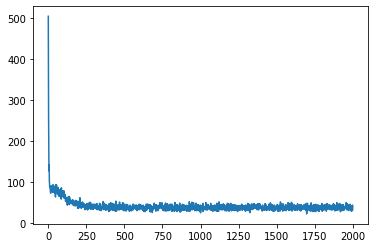

In [7]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.savefig("one_vector.png")
plt.show()


In [8]:
def predict(x_rm,graph):
    x.value = x_rm
    forward(graph=graph,monitor=False)
    return y_pre.value
    print(predict(x_rm[6],graph_sort),y_[6])
    #结果：19.88745280762896 22.9


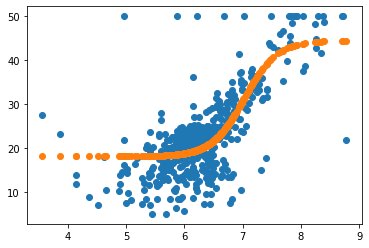

In [9]:
plt.scatter(x_rm,y_)
plt.scatter(x_rm,[predict(X,graph_sort) for X in x_rm])
plt.savefig("one_vector_duibi.png")
